Привет! Это ноутбук с выполненным тестовым заданием для компании JustAI.

<details>
<summary>Исходная формулировка задания:</summary>
К качестве датасета для анализа надо взять историю сообщений одного из каналов поддержки по нашим продуктам: https://t.me/aimylogic или https://t.me/jaicp
Что мы ожидаем от кандидата:

- выбора 2-3 метрик по выбранному каналу и анализа динамики по ним
- 2-3 инсайта, которые вы сможете извлечь из датасета
- код должен быть на python3+, приложен к письму полностью или ссылкой на github/bitbucket
</details>

Я выбрал канал t.me/jaicp, потому что там меньше участников → меньше сообщений → меньше по времени будет работать цикл парсинга, достаточно прозаично)

In [1]:
import sys
import itertools
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, Doc
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from telethon import TelegramClient
# Константы для подключения к телеграму по API и я положил в отдельный модуль, чтобы не светить ими на гитхабе :)
from API_CONSTANTS import API_HASH, API_ID, PHONE_NUMBER

## Подключение к API и парсинг
Выше мы импортировали библиотеку telethon для работы с api телеграма.  
Подключаемся к ней и парсим сообщения  

In [2]:
messages = []
async with TelegramClient('justai', API_ID, API_HASH) as client:
    channel_entity = await client.get_entity('jaicp')
    async for message in client.iter_messages(channel_entity):
        m = {'message_id': message.id, 
            'message': message.message,
            'date': message.date, 
            'from_id' : message.from_id.user_id if message.from_id is not None else None, # Если нужная мне инфа есть, то собираю ее, если нет, то None. + обращение к атрибуту None дает ошибку, так я ее избегаю
            'reply_to_top_id': message.reply_to.reply_to_top_id if message.reply_to is not None else None,
            'reply_to_msg_id': message.reply_to.reply_to_msg_id if message.reply_to is not None else None, 
            'media' : message.media,
            'replies' : message.replies.replies if message.replies is not None else None,
            }
        messages.append(m)
        # Сделал кустарный логгинг, чтобы понимать, что происходит
        # Поскольку сообщения нумеруются с начала, чем ближе к 1, тем ближе к концу парсинга
        sys.stdout.write('Осталось ~%s сообщений \r' % m['message_id'])
    sys.stdout.write('Закончили                     \r')

Делаем из списка датафрейм и посмотрим, верно ли подцепились типы данных

In [3]:
df = pd.DataFrame(messages)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6853 entries, 0 to 6852
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   message_id       6853 non-null   int64              
 1   message          6240 non-null   object             
 2   date             6853 non-null   datetime64[ns, UTC]
 3   from_id          6255 non-null   float64            
 4   reply_to_top_id  1149 non-null   float64            
 5   reply_to_msg_id  2621 non-null   float64            
 6   media            818 non-null    object             
 7   replies          3622 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4), int64(1), object(2)
memory usage: 428.4+ KB


Все окей, не будем переводить айдишники в инт, потому что там есть пропуски

## Предобработка датафрейма

Добавим столбцы с месяцем и годом, чтобы анализировать динамику чего-то со временем  
Поскольку чат существует несколько лет, месяцы лучше пусть будут с годом

In [4]:
df['month'] = df.date.dt.to_period('M')
df['year'] = df.date.dt.year
df.head()

/var/folders/gb/q28bt27s2d51svxknqcjyxp80000gn/T/ipykernel_47150/3395192116.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df.date.dt.to_period('M')


,message_id,message,date,from_id,reply_to_top_id,reply_to_msg_id,media,replies,month,year
0,7156,"Коллеги, \nроботы перестали отвечать на звонки...",2023-01-16 08:38:29+00:00,1.761985e+09,NaN,NaN,None,0.0,2023-01,2023
1,7155,"Всем привет, коллеги!\nПодскажите, пожалуйста,...",2023-01-16 07:36:13+00:00,3.723402e+08,NaN,NaN,None,0.0,2023-01,2023
2,7154,intent или intent! ?,2023-01-16 00:17:18+00:00,5.210382e+07,7147.0,7150.0,None,NaN,2023-01,2023
3,7153,None,2023-01-15 11:53:52+00:00,6.232325e+07,NaN,NaN,None,NaN,2023-01,2023
4,7152,"кажется, дело не в контексте, потому что глоба...",2023-01-13 13:05:35+00:00,4.670724e+08,7147.0,7150.0,None,NaN,2023-01,2023


## Исследование данных

По заданию нужно проанализировать 2-3 метрики. Постараюсь выбрать их осмысленно, чтобы из них можно было получить какие-то полезные инсайты. Например, можно было бы посмотреть среднюю длину сообщений, но я пока не могу придумать, как это может нам помочь в случае с публичным чатом техподдержки.  

Что я придумал:  
- Количество сообщений в чате за месяц — по нему можно прикинуть текущую популярность и/или «проблемность» продукта (в идеале эти данные смотреть вместе с данными о популярности продукта из другого источника)
- Процент «отвеченных сообщений» в месяц — косвенная метрика «работоспособности» чата. В идеале, конечно, смотреть именно процент «решенных проблем», но для этого их нужно разметить ;(
- Топ-10 самых частотных лемм за месяц — пока предварительно я не уверен, даст нам это какие-то прикольные инсайты или нет, но есть шанс, что вылезут леммы, касающиеся самых частых проблем в этом периоде или что-то такое

Какие у меня еще есть нереализованные идеи:
- Можно было бы классифицировать тексты по эмоциональной окраске и посмотреть, как меняется накал страстей в чате. (или, если мы будем размечать что-то вручную, это тоже можно разметить, но мне изначально пришла в голову идея поискать какую-то предобученную модель)
- Можно все-таки разметить «проблемы» и ответы на них и смотреть среднее время ответа. Либо просто втупую посчитать время до первого ответа, ничего не размечая (для этого я спарсил reply_to и тд)

#### Сообщений в чате за месяц

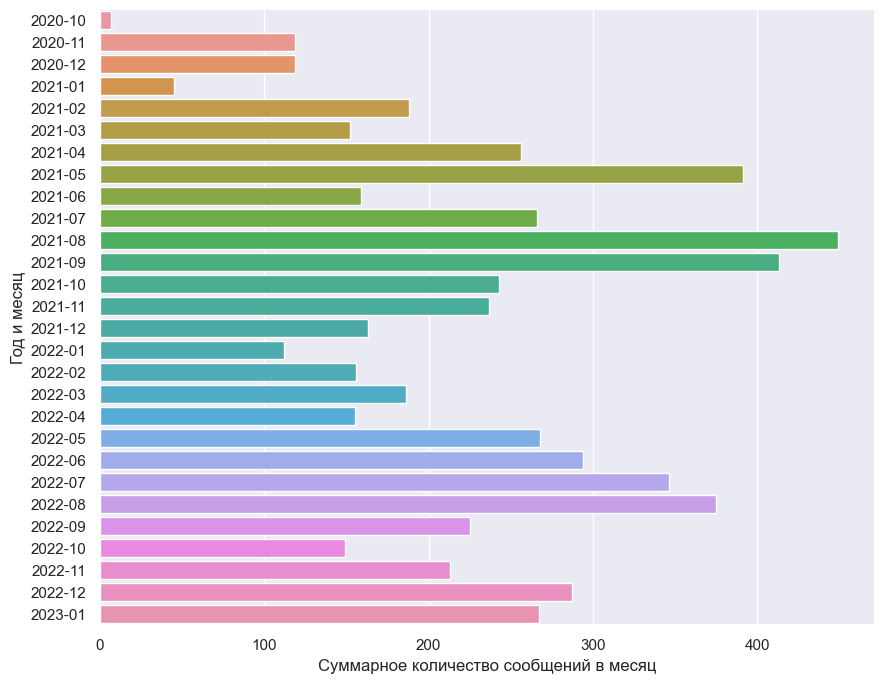

In [5]:
sns.set(rc={'figure.figsize':(10,8)})

temp = df.dropna(subset='message').groupby('month', as_index=False).size() # Дропаю пропуски по message, потому что это сообщение о том, что пользователь вступил
sns.barplot(data=temp, y='month', x='size', orient='h')
plt.xlabel('Суммарное количество сообщений в месяц')
plt.ylabel('Год и месяц'); 

Что видим:
- Пик пришелся на август-сентябрь 2021 года причем в июле и октябре сообщений уже сильно меньше, возможно, в этот период вышло какое-то нестабильное обновление. Мб продукт попал в какую-то новость и в него набежало много новых пользователей.
- Примерно через год — в июле-августе сообщений снова стало много в сравнении с соседними периодами, налицо перидичность — почему-то продуктом чаще пользуются в конце лета.
- Мы не видим растущего тренда. Так что если количество пользователей продукта растет (и мы всем им рассказываем о чате), то можно сказать, что все очень даже неплохо — пользователей больше, а проблем с продуктом не больше. (а если количество пользователей стагнирует или убывает, то новости наоборот не очень хорошие, сообщений в чате все еще почти всегда минимум 200 за месяц...)

### Доля отвеченных сообщений за месяц

К сожалению, тут я заметил, что почему-то API часто отдает None в replies, и если реплаи есть, и если их нет, поэтому, эту метрику мы анализируем ОЧЕНЬ ОГРАНИЧЕННО  
Дополнительно проверяем, чтобы не учитывать тут сообщения, которые сами по себе являются реплаями, так как предполагаем, что на них и не надо было отвечать

*Уже после того, как закончил делать задание, заметил, что reply_to и тд приходят вроде бы нормально, поэтому количество реплаев можно было бы восстановить по этим столбцам, но уже не успеваю это сделать ;(*

In [6]:
# Поскольку реплаев может быть больше единицы, но для этой метрики это нас не интересует, переведем все в boolean
df.loc[(df.replies == 0) & (df.reply_to_top_id.isna()) & (df.reply_to_msg_id.isna()), 'is_replied'] = False
df.loc[(df.replies > 0) & (df.reply_to_top_id.isna()) & (df.reply_to_msg_id.isna()), 'is_replied'] = True
df.head()

,message_id,message,date,from_id,reply_to_top_id,reply_to_msg_id,media,replies,month,year,is_replied
0,7156,"Коллеги, \nроботы перестали отвечать на звонки...",2023-01-16 08:38:29+00:00,1.761985e+09,NaN,NaN,None,0.0,2023-01,2023,False
1,7155,"Всем привет, коллеги!\nПодскажите, пожалуйста,...",2023-01-16 07:36:13+00:00,3.723402e+08,NaN,NaN,None,0.0,2023-01,2023,False
2,7154,intent или intent! ?,2023-01-16 00:17:18+00:00,5.210382e+07,7147.0,7150.0,None,NaN,2023-01,2023,NaN
3,7153,None,2023-01-15 11:53:52+00:00,6.232325e+07,NaN,NaN,None,NaN,2023-01,2023,NaN
4,7152,"кажется, дело не в контексте, потому что глоба...",2023-01-13 13:05:35+00:00,4.670724e+08,7147.0,7150.0,None,NaN,2023-01,2023,NaN


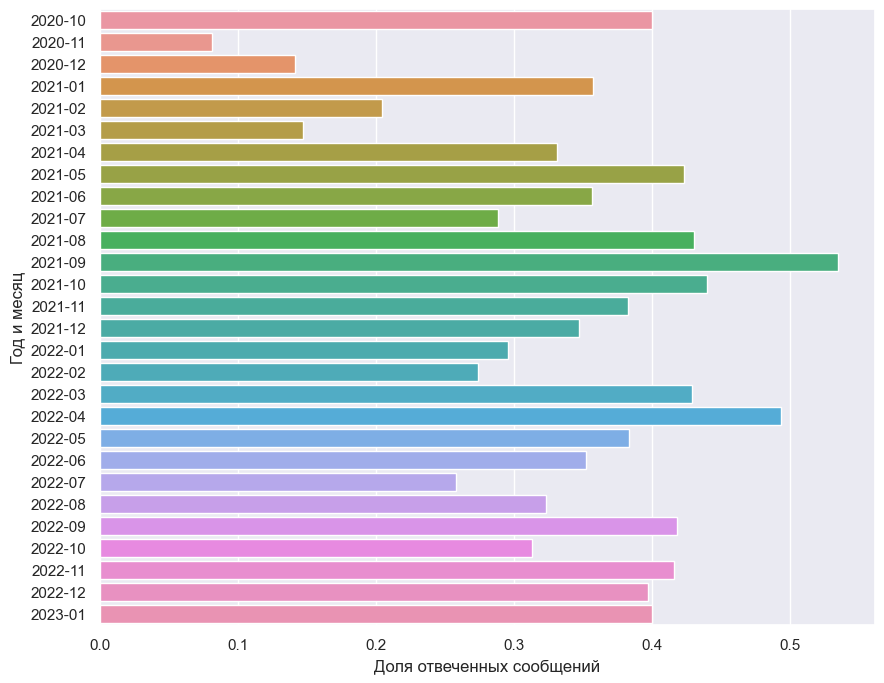

In [7]:
temp = df.dropna(subset='is_replied').groupby('month', as_index=False).is_replied.mean()
sns.barplot(data=temp, y='month', x='is_replied', orient='h')
plt.xlabel('Доля отвеченных сообщений')
plt.ylabel('Год и месяц'); 

Картинка похожа на график с количеством сообщений за месяц. Но с учетом того, что ты не знаем, одинакова ли доля «выпавших» сообщений, я бы поосторожничал и не стал делать никакие выводы ;(

Но сделаем вид, что оставшаяся часть репрезентативна, тогда:
- Поскольку мы не учитываем сообщения, которые являются реплаями, доля меньше половины в большинстве месяцев для меня выглядит довольно напряжной. Но делать выводы рано, даже если выпавшие сообщения нам ничего не испортили, возможно, что дело в том, что люди задают вопрос не одним сообщением, а несколькими, а ответить через функционал телеграма можно только на одно.
- Доля от месяца к месяцу ведет себя достаточно волатильно и есть что-то похожее на нисходящий тренд, стоит исследоват это получше каким-нибудь нормальным способом (все-таки точно отделить вопросы с проблемами и ответы на них...).

### Самые частотные леммы за месяц

Сначала лемматизируем текст с помощью средств библиотеки natasha

In [8]:
# Инициализируем все нужное
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
russian_stopwords = stopwords.words("russian")

In [9]:
# Тут я добавляю в список стоп-слов те, которые оказались частотными, но на мой взгляд не имеют смысла
russian_stopwords.extend(['это', 'https', 'добрый', 'to', 'день', 'com', 'привет', '...'])

In [10]:
def lemmatize(text):
    '''
    Функция для лемматизации текста с помощью средств библиотеки natasha
    text — текст сообщения для лемматизации
    Функция возвращает список лемм в сообщении, исключая из него одиночные символы и стоп-слова
    '''
    if text is None: return None
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    return [_.lemma for _ in text.tokens if len(_.lemma) > 1 and _.lemma not in russian_stopwords] # Убираем леммы с длиной до 2, потому что они для нас не важны, и бессмысленные слова из корпуса стоп-слов


In [11]:
df['lemmas'] = df.message.apply(lemmatize)
df.lemmas.head()

0    [коллега, робот, перестать, отвечать, звонок, ...
1    [весь, коллега, подскажите, пожалуйста, кто-ни...
2                                     [intent, intent]
3                                                 None
4    [казаться, дело, контекст, глобальный, интент,...
Name: lemmas, dtype: object

Дальше собираем самые частотные слова за месяц  
Я делаю это циклом: собираю леммы за каждый месяц в один список, считаю по ним частотность, а потом собираю топ-10 в отдельный датафрейм. Немного костыльненько, но это быстрое решение, если этот код будет переиспользоваться, то лучше будет переписать

In [12]:
months_freqs = pd.DataFrame(columns=['month'] + ['top_'+str(i) for i in range(1,11)])
for month in df.month.unique():
    month_df = df[df.month == month]
    sum_lemmas = list(
        itertools.chain.from_iterable(month_df.lemmas.dropna())
    )
    temp_df = pd.DataFrame(FreqDist(sum_lemmas).most_common(10))
    temp_df = temp_df.transpose()
    temp_df.columns = ['top_'+str(i) for i in range(1,11)]
    temp_df['month'] = month
    months_freqs = pd.concat([months_freqs, temp_df])
months_freqs

,month,top_1,top_2,top_3,top_4,top_5,top_6,top_7,top_8,top_9,top_10
0,2023-01,бот,мочь,стейт,работать,сделать,нужный,весь,который,сообщение,пользователь
1,2023-01,52,41,38,35,31,30,27,25,24,21
0,2022-12,весь,бот,мочь,интент,проблема,работать,запрос,ошибка,просто,который
1,2022-12,53,38,32,30,29,25,24,21,20,20
0,2022-11,весь,проблема,работать,мочь,бот,коллега,спасибо,поддержка,робот,нужный
1,2022-11,44,25,24,24,20,20,20,20,18,17
0,2022-10,весь,мочь,бот,подсказать,спасибо,стейт,звонок,пожалуйста,который,коллега
1,2022-10,29,24,21,14,14,12,11,11,11,10
0,2022-09,бот,мочь,спасибо,весь,пользователь,кнопка,который,нужный,ru,jaicp
1,2022-09,50,29,29,25,21,18,16,16,14,14


Ну что видим:
- Я явно переоценил эту гипотезу, на первый взгляд не вижу здесь никаких полезных инсайтов;
- В 2020 году и начале 2021 частоты самых лемм достаточно низкие — в чате было мало пользователей и мало сообщений;
- На 1-3 местах часто встречается «бот» и «мочь». «Бот» говорит о тематике продукта, «мочь» говорит нам о тематике чата — это чат техподдержки, так что, скорее всего, люди много писали что-то типа «не могу»;
- В топе часто встречается «спасибо» — это хороший знак, видимо, в чате кому-то помогают;
- Ну и в общем я бы сказал, что картина просто соответствует чату тех поддержки;
- Наверное, можно сказать, что раз в частотных леммах нет никаких слов, которые говорили бы о сильном недовольстве, а «спасибо» встречается либо чаще, либо не сильно реже, чем «пожалуйста», «мочь» и «проблема», то чат в общем справляется со своей задачей — проблемы решаются, шквала недовольных нет. (но, конечно, эту гипотезу лучше проверять, почитав сообщения самостоятельно)

Идея:
- Если бы я работал с продуктом больше времени и знал, что у него есть какие-то конкретные проблемы, можно было бы целенаправленно поискать леммы, связанные именно с ними, и оценить, насколько часто эти проблемы встречаются в чате.

## Итоги

Мы спарсили и проанализировали сообщения из телеграм-чата техподдержки t.me/jaicp  
- Если честно, мне кажется, что мы не узнали ничего сильно полезного, потому что 1) Эти данные плохо работают в отрыве от всех остальных данных продукта; 2) Мне кажется, что простого парсинга чата недостаточно. Нужно еще как-то классифицировать или размечать сообщения. В случае с эмоциональной окраской я бы вобще начал с качественного, а не количественного анализа;
- В итоге все выводы/итоги и тд — всего лишь гипотезы, у меня нет ощущения, что я этим исследованием получил что-то репрезентативное.

Но в остальном:
- Пиковые периоды по количеству сообщений в чате — конец лета 2021 и 2022;
- Тренда на увеличение количества сообщений нет. Либо продукт не пользуется популярностью, либо про чат не узнают новые пользователи, либо, если продуктом пользуюется все больше и больше людей, все окей — он не проблемный, людям приходится не слишком часто писать в чат;
- Из-за бага API мы не можем точно посчитать долю отвеченных сообщений, но если предположить, что его нет, то в большинстве месяцев доля немного меньше 0.5, что не очень хорошо, поскольку мы не учитываем тут «сообщения-ответы», которые и не требуют ответа. При этом доля ответов достаточно волатильна и кажется, что есть тренд на снижение. Нужно исследовать дополнительно более подходящими методами;
- Самые частотные леммы соответствуют тематике чата, по результатам этой части исследования нет оснований предполагать, что в чате что-то идет не так.